<a href="https://www.kaggle.com/code/bhavinmoriya/hypothesis-testing?scriptVersionId=111695756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Often we have some sample and we believe that the sample represent some population. This could be statistically tested using Hypothesis testing :
1. There are two hypothesis
    - Null Hyp : What we believe is true.
    - Alternative Hyp : Which says what we believe is not true
2. Decide the threshold (denoted by $\alpha$) to reject Null hyp. Often we take $\alpha \le .05$. That is if statistics 
$\le \alpha$. We do not reject Null hyp (**We never accept null hyp, we either reject it or do not reject it**).

CREDITS : https://www.youtube.com/watch?v=CIbJSX-biu0


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import norm, gamma, uniform, beta, binom, geom, expon, poisson, t, ttest_1samp

# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pop1 = poisson.rvs(loc=18, mu=35, size=100_000)
pop2 = poisson.rvs(loc=18, mu=10, size=200_000)
pop = np.concatenate((pop1, pop2))

samp1 = poisson.rvs(loc=18, mu=30, size=100)
samp2 = poisson.rvs(loc=18, mu=10, size=200)
sample = np.concatenate((samp1, samp2))

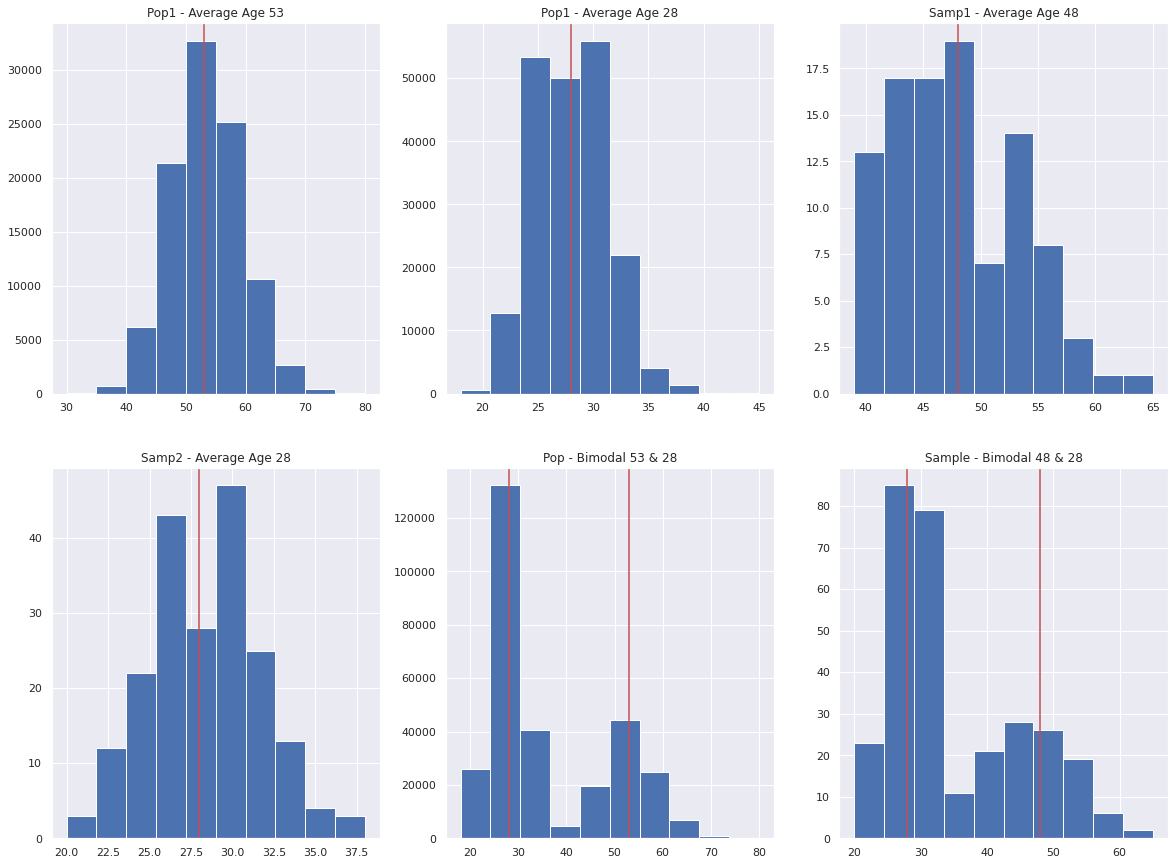

In [3]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.flatten()
ax[0].hist(pop1, label='Mean 53');
ax[0].axvline(53, c='r')
ax[0].set_title('Pop1 - Average Age 53')
ax[1].hist(pop2, label='Mean 28');
ax[1].axvline(28, c='r')
ax[1].set_title('Pop1 - Average Age 28')
ax[2].hist(samp1, label='Mean 28');
ax[2].axvline(48, c='r')
ax[2].set_title('Samp1 - Average Age 48')
ax[3].hist(samp2, label='Mean 28');
ax[3].axvline(28, c='r')
ax[3].set_title('Samp2 - Average Age 28');

ax[4].hist(pop, label='Mean 28');
ax[4].axvline(28, c='r')
ax[4].axvline(53, c='r')
ax[4].set_title('Pop - Bimodal 53 & 28');
ax[5].hist(sample, label='Mean 28');
ax[5].axvline(28, c='r')
ax[5].axvline(48, c='r')
ax[5].set_title('Sample - Bimodal 48 & 28');
# pop1

We can see distributions are different. Of course, we did know apriori that is the case. But imagine that, if we had just been given the population and sample without no information, then we could use T-test to see if null hyp (sample is from population) is true or not.

In [4]:
t_stat, p = ttest_1samp(a=sample, # sample data
           popmean=pop.mean() #population mean
           )
print(f't-Statistics : {t_stat} and p-value : {p}')

t-Statistics : -2.6282749263765526 and p-value : 0.009025104387236093


We see t-statistic (how much sample deviates from the pop mean) is about -2.547 and pvalue is about .011 (which is the probability that sample is as extreme as it is by chance assuming null hyp). In other words, there is about 1% prob that the sample is by chance assuming sample represent the data. As 1% < 5% we should reject the null hyp (We are setting conf level to 95%. Had we set it to 99%, we can not reject null hyp, as we would be expecting p value less than 100 - 99 = 1%).

t-stat also help us to test hyp. We shall reject the null hypothesis if the t-stats lie outside the desired quantiles, which depends on the confidence level we set up. We shall set up 95%. Hence we shall check the .025 and .975 quantile.

In [5]:
if t.ppf(.025, df=sample.shape[0]-1) <= t_stat and t_stat <= t.ppf(.975, df=sample.shape[0]-1):
    print('We will not reject the null Hyp and hence sample represent the population')
else:
    print("We reject the null hyp. Sample does not represent the population")


We reject the null hyp. Sample does not represent the population


We could get this from p-value as well. If we set confidence level to 95% then $\alpha = 1-.95=.05$. So if p-value is <= $\alpha$ we can reject the null hyp, which is the case here. We could also calculate p-value from t_stat, as follows:

In [6]:
t.cdf(t_stat, df=sample.shape[0]-1) \
* 2 # as we are conducting two tailed test

0.009025104387236093

Which is same as p value we got earlier. This actually tell that with 95% conf level if we draw conf int then CI will not contain the pop mean at 95% conf level. Let's do it!

In [7]:
sigma = sample.std() / np.sqrt(sample.shape[0])
t.interval(alpha=.95,
          loc=sample.mean(),
          scale=sigma,
          df=sample.shape[0]-1)

(33.65713003347189, 35.94953663319478)

As we see pop_mean is outside the CI.

In [8]:
interval = np.zeros(shape=(25,2))
means = np.zeros(25)
for i in range(25):
    sample = np.random.choice(pop, size=300)
    sigma = sample.std() / np.sqrt(300)
    interval[i] = t.interval(alpha=.95,
          loc=sample.mean(),
          scale=sigma,
          df=299)
    means[i] = sample.mean()

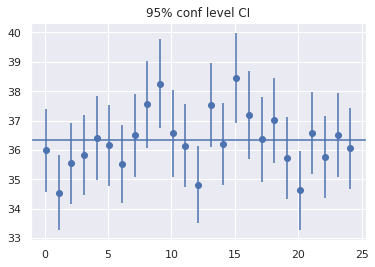

In [9]:
plt.errorbar(x=np.arange(.1,25,1),
            y=means,
            yerr = [(top-bot)/2 for bot, top in interval],
            fmt='o')
plt.axhline(pop.mean())
plt.title('95% conf level CI');

There were 3 interval which does not contain popmean and hence about 12% are off, which is way more compare to 5%.

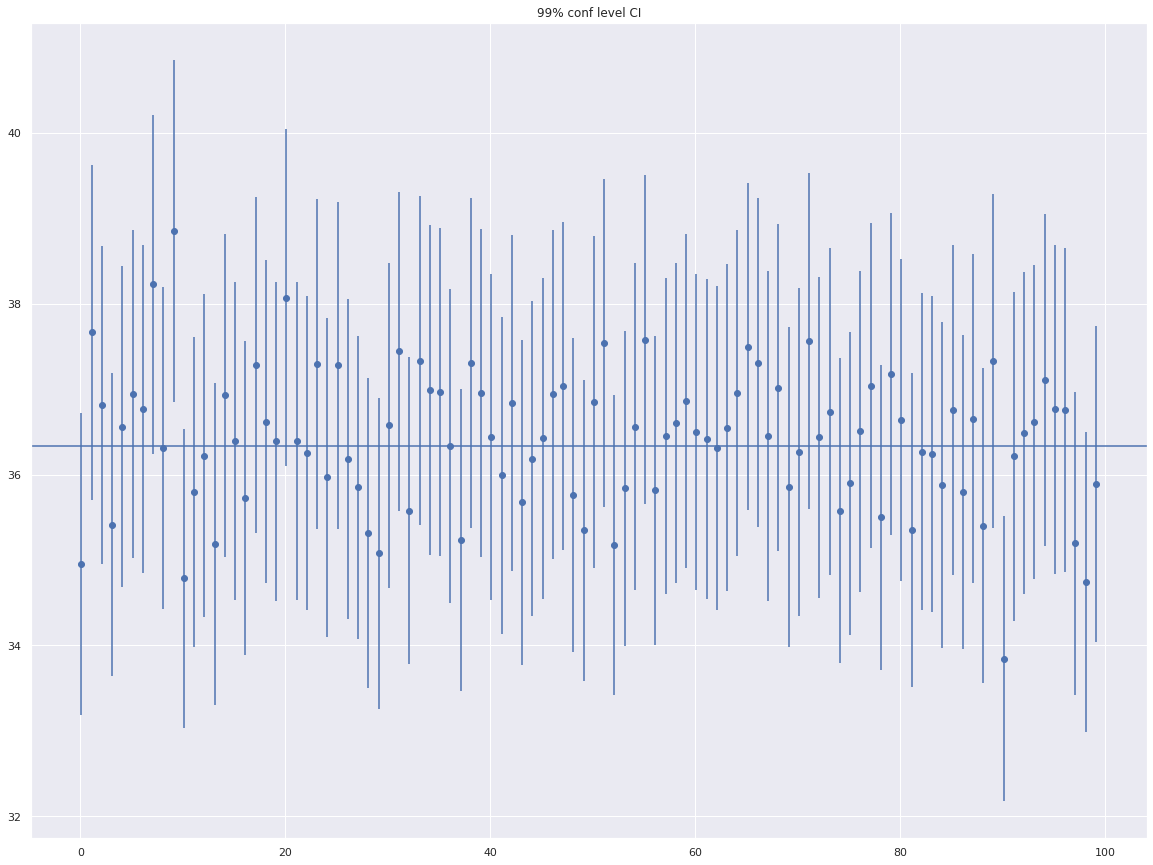

In [10]:
# story is different if we set 99% conf level
interval = np.zeros(shape=(100,2))
means = np.zeros(100)
for i in range(100):
    sample = np.random.choice(pop, size=300)
    sigma = sample.std() / np.sqrt(300)
    interval[i] = t.interval(alpha=.99,
          loc=sample.mean(),
          scale=sigma,
          df=299)
    means[i] = sample.mean()
    
# pplots
plt.figure(figsize=(20,15))
plt.errorbar(x=np.arange(0.1,100,1),
            y=means,
            yerr = [(top-bot)/2 for bot, top in interval],
            fmt='o')
plt.axhline(pop.mean())
plt.title('99% conf level CI');

Only 1 is off, which is fine as 1% is expected. So null hyp (NH) will not be rejected in this case, as the threshold is changed. To be more precise, this test does not give enough evidence to reject NH.

# Two sample t-test

Given two samples, the test would do hyp testing.
1. NH is Two samples are in the same group
2. Alternative hyp (AH) : They are from different group


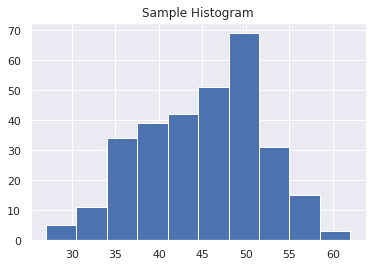

In [11]:
samp1 = poisson.rvs(loc=18, mu=30, size=200)
samp2 = poisson.rvs(loc=18, mu=20, size=100)
sample3 = np.concatenate((samp1, samp2))
plt.hist(sample3)
# plt.axvline(48,c='r')
# plt.axvline(38,c='r')
plt.title('Sample Histogram');

In [12]:
print(f'Sample mean is : {sample.mean()}')

Sample mean is : 35.89
